In [33]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib as mpl
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator

In [25]:
def plot_fluxes(G, voronoi, inner_radars, countries, crs, ax, 
                extent=[-4, 16, 41, 56], max_flux=100, bird_scale=1, cbar=True):

    f = ShapelyFeature(countries.geometry,
            ccrs.PlateCarree(), edgecolor='white')
    ax.set_extent(extent)
    ax.add_feature(f, facecolor='lightgray', zorder=0)

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                     observed = voronoi.observed,
                                     geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                     crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G,'flux').values()))
    fluxes *= bird_scale
    edge_widths = np.minimum(fluxes, max_flux) / (0.25 * max_flux) + 1.2

    c_radar = 'lightgray'
    c_marker = '#0a3142'
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else c_radar for n, n_data in G.nodes(data=True)]
    node_colors = [c_radar for n, n_data in G.nodes(data=True)]

    cmap = cm.get_cmap('YlOrRd')

    norm = plt.Normalize(0, max_flux)
    edge_colors = cmap(norm(fluxes))

    nx.draw(G, pos=pos, with_labels=False, node_size=9000/len(G), node_color=node_colors, ax=ax, 
            options={'arrowsize': edge_widths*200}, connectionstyle="arc3,rad=0.1", 
                  edge_color=edge_colors, width=edge_widths, zorder=2)

    gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=1.5)
    gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=2)
    gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, extent=extent, zorder=4, color=c_marker, s=6)


    if cbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, extend='max', pad=0.1)
        cbar.set_label(label=r'net migratory flux [birds per 24h]',size=24, labelpad=18)
        cbar.ax.tick_params(labelsize=14) 

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, color='gray', alpha=0.25, linestyle='--')

    xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
    yspacing = FixedLocator([40, 45, 50, 55])
    gl.xlocator = xspacing
    gl.ylocator = yspacing

    ax.set_extent(extent)

    return ax

In [26]:
base_dir = '/home/fiona/birdMigration'
model_dir = osp.join(base_dir, 'results', 'abm', 'FluxRGNN', 'test_2017', 'final')
prep_dir = osp.join(base_dir, 'data', 'preprocessed', '1H_voronoi_ndummy=25', 'abm', 'fall', '2017')
shape_dir = osp.join(base_dir, 'data', 'shapes')
figure_dir = '/home/fiona/birdMigration/data/plots/final'

In [35]:
c_radar_loc = '#cc3300'
c_radar_area = '#347B98'
c_marker = '#0a3142'
c_boundary = '#092834'
c_boundary_rgb = (9/255, 40/255, 52/255, 0.2)
c_boundary_light = '#0a3142'
c_text = '#262626'
c_countries = 'lightgray'

### ***Analysis of spatial fluxes***

In [27]:
path = osp.join(model_dir, 'performance_evaluation', '1-24')
corr_d2b = pd.read_csv(osp.join(path, 'agg_corr_d2b_per_trial.csv'))
corr_angles = pd.read_csv(osp.join(path, 'agg_corr_angles_per_trial.csv'))
bins_per_trial = pd.read_csv(osp.join(path, 'agg_bins_per_trial.csv'))

with open(osp.join(path, 'agg_overall_corr.pickle'), 'rb') as f:
    overall_corr = pickle.load(f)
    
mean_corr = np.mean(list(overall_corr.values()))
std_corr = np.std(list(overall_corr.values()))
print(f'overall correlation = {mean_corr} +/- {std_corr}')

mean_acc = bins_per_trial.accuracy.mean()
std_acc = bins_per_trial.accuracy.std()
print(f'overall accuracy of directions = {mean_acc} +/- {std_acc}')

overall correlation = 0.5794126287451336 +/- 0.009119940355229892
overall accuracy of directions = 0.8702291831041917 +/- 0.007244720459744943


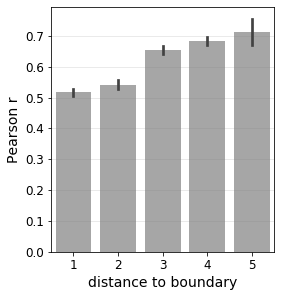

In [29]:
fig, ax = plt.subplots(figsize=(4,4.5))
sb.barplot(x='d2b', y='corr', data=corr_d2b.dropna(), ax=ax, 
           color='#a6a6a6', ci='sd')
ax.set_xlabel('distance to boundary', fontsize=14)
ax.set_ylabel('Pearson r', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_acc_fluxes_per_d2b_trial_std.png', bbox_inches='tight', dpi=200)

### ***Analysis of source/sink terms***

In [23]:
path = osp.join(model_dir, 'performance_evaluation', '1-24')
all_corr_source = pd.read_csv(osp.join(path, 'agg_source_corr_per_trial.csv'))
all_corr_sink = pd.read_csv(osp.join(path, 'agg_sink_corr_per_trial.csv'))

print('######## source ##########')
mean_corr = all_corr_source['corr'].aggregate(np.nanmean)
std_corr = all_corr_source['corr'].std()
print(f'overall correlation = {mean_corr} +/- {std_corr}')
print('########  sink  ##########')
mean_corr = all_corr_sink['corr'].mean()
std_corr = all_corr_sink['corr'].std()
print(f'overall correlation = {mean_corr} +/- {std_corr}')

######## source ##########
overall correlation = 0.6008964229467678 +/- 0.02054831217013652
########  sink  ##########
overall correlation = 0.5968686851473788 +/- 0.024549400268507666


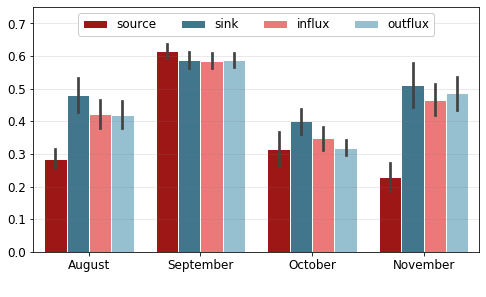

In [10]:
corr_source = pd.read_csv(osp.join(path, 'agg_source_corr_per_month_and_trial.csv'))
corr_sink = pd.read_csv(osp.join(path, 'agg_sink_corr_per_month_and_trial.csv'))
corr_influx = pd.read_csv(osp.join(path, 'agg_corr_influx_per_month.csv'))
corr_outflux = pd.read_csv(osp.join(path, 'agg_corr_outflux_per_month.csv'))

corr_sink['type'] = 'sink'
corr_source['type'] = 'source'
corr_influx['type'] = 'influx'
corr_outflux['type'] = 'outflux'

all_corr = pd.concat([corr_source[['trial', 'corr', 'type', 'month']], 
                      corr_sink[['trial', 'corr', 'type', 'month']],
                     corr_influx[['trial', 'corr', 'type', 'month']],
                     corr_outflux[['trial', 'corr', 'type', 'month']]])

palette = {"source": "#B50000", "sink": "#347B98", "influx": "#ff6666", "outflux": "#8dc3d8"}
fig, ax = plt.subplots(figsize=(8,4.5))
sb.barplot(data=all_corr, x='month', hue='type', y='corr', ax=ax,
           palette=palette, ci='sd', edgecolor="white")
ax.set_ylabel('')
ax.set_xlabel(' ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(['August', 'September', 'October', 'November'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(all_corr.type.unique()), framealpha=1, fontsize=12)
ax.set(ylim=(0, 0.75))
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
#fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_source_sink_fluxes_per_month_trial_std_final.png', bbox_inches='tight', dpi=200)

### ***Visualisation of 24h fluxes***

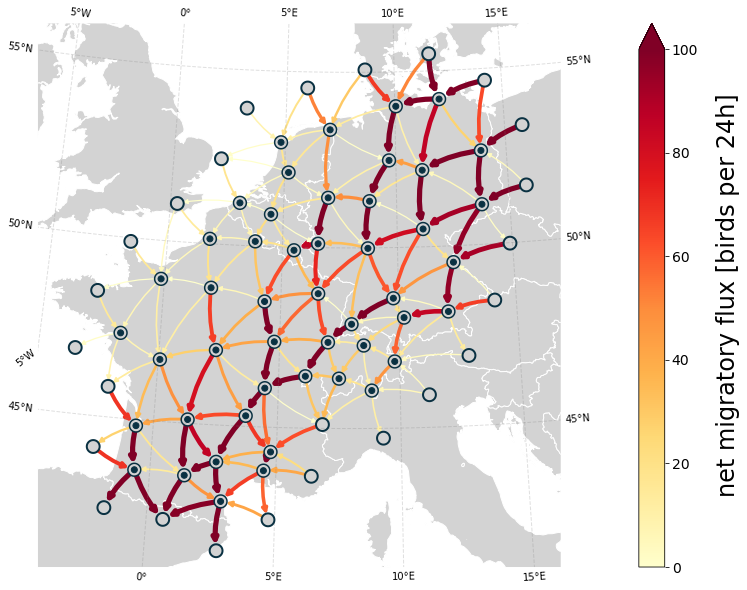

In [12]:
trial = 3

G = nx.read_gpickle(osp.join(model_dir, 'performance_evaluation', '1-24', f'model_fluxes_{trial}.gpickle'))
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
countries = gpd.read_file(osp.join(shape_dir, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})

ax = plot_fluxes(G, voronoi, inner_radars, countries, crs.proj4_init, ax, cbar=True)

fig.savefig(osp.join(figure_dir, f'abm_avg_24h_fluxes_model_trial{trial}.png'), bbox_inches='tight', dpi=200)

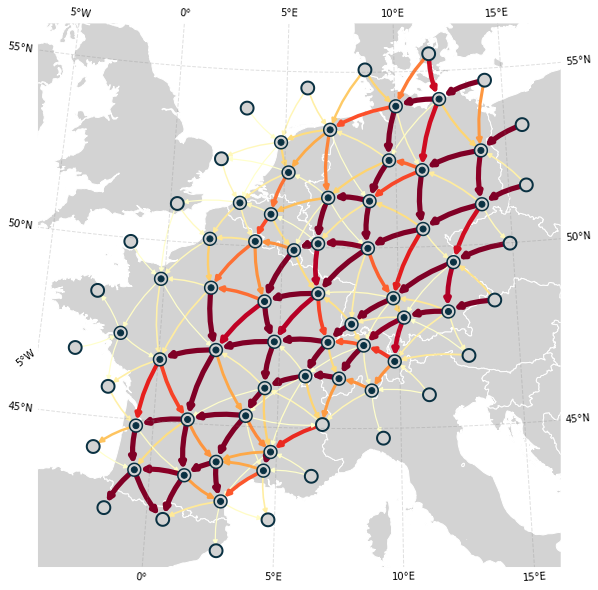

In [14]:
G = nx.read_gpickle(osp.join(model_dir, 'performance_evaluation', '1-24', f'gt_fluxes.gpickle'))
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
countries = gpd.read_file(osp.join(shape_dir, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})

ax = plot_fluxes(G, voronoi, inner_radars, countries, crs.proj4_init, ax, cbar=False)

fig.savefig(osp.join(figure_dir, f'abm_avg_24h_fluxes_gt.png'), bbox_inches='tight', dpi=200)

### ***Time series comparison***

In [31]:
voronoi_data = pd.read_csv(osp.join(model_dir, 'performance_evaluation', '24-24', 'voronoi_summary.csv'))

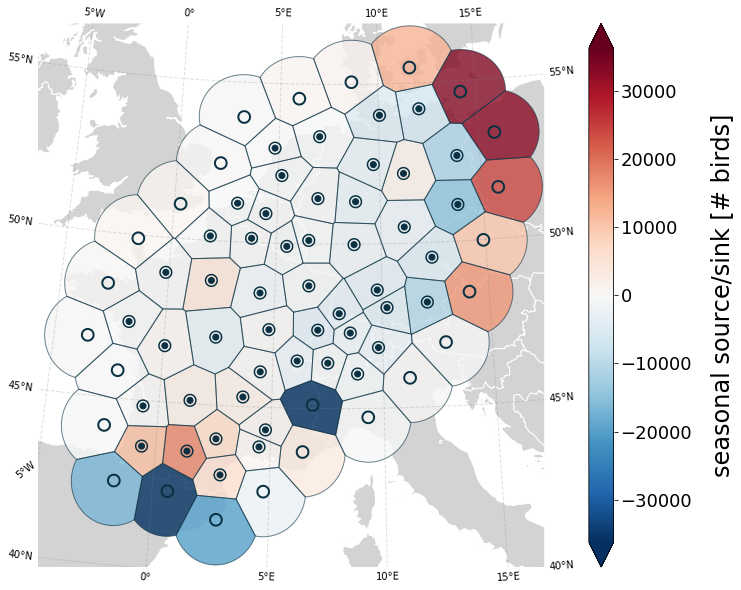

In [50]:
fig, ax = plt.subplots(figsize=(16, 10), subplot_kw = {'projection' : crs})
extent = [-4.5, 16.5, 40, 56.5]

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)

trial = 2

voronoi['net_flux'] = voronoi_data[f'net_flux_{trial}'].values #/ 1e6
voronoi['net_s'] = voronoi_data[f'net_source_sink_{trial}'].values #/ 1e6
voronoi['net_s'] *= voronoi.area_km2

abs_max_f = max(voronoi[f'net_flux'].max(), -voronoi[f'net_flux'].min())
abs_max_s = max(voronoi[f'net_s'].max(), -voronoi[f'net_s'].min())
abs_max = max(abs_max_f, abs_max_s)
norm = mpl.colors.Normalize(vmin=-abs_max*0.75, vmax=abs_max*0.75)

gplt.choropleth(voronoi.query('boundary == 1'), ax=ax, hue=f'net_flux', 
                norm=norm, cmap='RdBu_r', alpha=0.8, zorder=1)
gplt.choropleth(voronoi.query('boundary == 0'), ax=ax, hue=f'net_s', 
                norm=norm, cmap='RdBu_r', alpha=0.8, zorder=1)
gplt.polyplot(voronoi, ax=ax, 
              edgecolor=c_boundary_light, alpha=0.6, zorder=1)

points = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]
coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 observed = voronoi.observed,
                                 geometry = points), 
                                 crs='epsg:4326').to_crs(crs.proj4_init)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, 
              zorder=3, edgecolor=c_marker, extent=extent, linewidth=1.5)
gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, 
              zorder=3, edgecolor=c_marker, extent=extent, linewidth=2)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, 
               zorder=4, color=c_marker, extent=extent, s=6)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('RdBu_r'), norm=norm)
cbar = plt.colorbar(sm, extend='both')
cbar.set_label(label='seasonal source/sink [# birds]', size=24, labelpad=18)
cbar.ax.tick_params(labelsize=18) 
ax.set_extent(extent)

#fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', f'seasonal_source_sink_trial_{trial}.png'), bbox_inches='tight', dpi=200)